## Load data

In [1]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd


data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [2]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

## Feature construction

In [3]:
from dataAnalysis.FeatureImportance import FeatureImportance
feature_importance = FeatureImportance(X_train)

## Graph construction (Other function than in the training step because of limitations in the torch.quantile function)

In [4]:
import torch
import numpy as np
from dataAnalysis.Constants import *

def to_tensor(df):
    return torch.Tensor(list(df.values))

def get_quantil_tensor():
    number_of_quantiles = 10
    q = torch.arange(0, 1, 1/number_of_quantiles)
    q = torch.Tensor([0.025,0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 0.975, 1])
    return q

def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

def get_quantile_indices(tensor, quantiles):
    quantile_indices = []
    all_indices = torch.Tensor([])
    prev_quantile = -1e-4
    indices_control = torch.arange(0, tensor.shape[0])
    for i in range(quantiles.nelement()):
        indices_u = (tensor > prev_quantile).nonzero(as_tuple=True)[0] # (tensor > prev_quantile and tensor <= quantiles[i]).nonzero(as_tuple=True)[0]
        indices_o = (tensor <= quantiles[i]).nonzero(as_tuple=True)[0]
        indices = torch.from_numpy(np.intersect1d(indices_u, indices_o))
        quantile_indices.append(indices)
        prev_quantile = quantiles[i]
    return quantile_indices


def create_node_features(node_type, quantiles):
    nodes_features = []
    prev_quantile = torch.Tensor([0])
    for i in range(quantiles.nelement()):
        node_features = [prev_quantile.item(), quantiles[i].item(), get_quantil_tensor()[i].item()]
        prev_quantile = quantiles[i]
        nodes_features.append(node_features)
    return torch.tensor(nodes_features)

## Other function than in the training step because of limitations in the torch.quantile function
def add_features_and_edges(graph):
    for i, feature_name in enumerate(FEATURES):
        if feature_name == SEX_CATEGORY_COLUMN_NAME or feature_name == AGE_COLUMN_NAME:
            continue
        feature_vector = graph[PATIENT_NAME].x[:, i]
        sorted_features, sorted_indices = torch.sort(feature_vector)
        sorted_indices
        start_index = 0
        size = feature_vector.shape[0]
        source_edge_list = None
        target_edge_list = None
        node_quantiles = []
        for i, q in enumerate(get_quantil_tensor()):
            end_index = (torch.floor(q*size)).type(torch.long) -1 
            source_edges = sorted_indices[start_index:end_index]
            target_edges = torch.ones(source_edges.shape[0]) * i
            source_edge_list = source_edges if source_edge_list is None else torch.concat((source_edge_list, source_edges))
            target_edge_list = target_edges if target_edge_list is None else torch.concat((target_edge_list, target_edges))
            start_index = end_index
            node_quantiles.append(sorted_features[end_index])
        target_edge_list = target_edge_list.type(torch.long)
        graph[PATIENT_NAME, EDGE_TYPE, feature_name].edge_index = torch.stack([source_edge_list, target_edge_list])
        node_quantiles = torch.tensor(node_quantiles)
        graph[feature_name].x = create_node_features(feature_name, node_quantiles)
        
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from imblearn.under_sampling import RandomUnderSampler

graph = HeteroData()
graph[PATIENT_NAME].x = torch.from_numpy(feature_importance.X_all_fv).type(torch.float)
add_features_and_edges(graph)
graph[PATIENT_NAME].x = normalize(graph[PATIENT_NAME].x)
graph = T.ToUndirected()(graph)

## Model construction

In [5]:
from torch_geometric.nn import GATConv, to_hetero,Linear, HeteroConv, SAGEConv
from torch_geometric.nn.conv import HANConv
from torchmetrics import AUROC

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        hidden_channels = 128
        out_channels = 1
        super(GraphNeuralNetwork, self).__init__()
        
        self.conv1 = SAGEConv((-1,-1), hidden_channels, normalize=True,aggr = "mean",root_weight = True)
        self.conv_end = SAGEConv(hidden_channels, out_channels, aggr = "mean", root_weight = True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv_end(x, edge_index)
        return x    

/home/dwalke/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Load trained model

In [6]:
model = GraphNeuralNetwork()
print(graph.metadata())
model = to_hetero(model, graph.metadata(), aggr='sum')
model.load_state_dict(torch.load("heterogeneous_gnn_state_dict.pt"))
model.eval()

(['PATIENT', 'HGB', 'WBC', 'RBC', 'MCV', 'PLT'], [('PATIENT', 'HAS', 'HGB'), ('PATIENT', 'HAS', 'WBC'), ('PATIENT', 'HAS', 'RBC'), ('PATIENT', 'HAS', 'MCV'), ('PATIENT', 'HAS', 'PLT'), ('HGB', 'rev_HAS', 'PATIENT'), ('WBC', 'rev_HAS', 'PATIENT'), ('RBC', 'rev_HAS', 'PATIENT'), ('MCV', 'rev_HAS', 'PATIENT'), ('PLT', 'rev_HAS', 'PATIENT')])


GraphModule(
  (conv1): ModuleDict(
    (PATIENT__HAS__HGB): SAGEConv((-1, -1), 128, aggr=mean)
    (PATIENT__HAS__WBC): SAGEConv((-1, -1), 128, aggr=mean)
    (PATIENT__HAS__RBC): SAGEConv((-1, -1), 128, aggr=mean)
    (PATIENT__HAS__MCV): SAGEConv((-1, -1), 128, aggr=mean)
    (PATIENT__HAS__PLT): SAGEConv((-1, -1), 128, aggr=mean)
    (HGB__rev_HAS__PATIENT): SAGEConv((-1, -1), 128, aggr=mean)
    (WBC__rev_HAS__PATIENT): SAGEConv((-1, -1), 128, aggr=mean)
    (RBC__rev_HAS__PATIENT): SAGEConv((-1, -1), 128, aggr=mean)
    (MCV__rev_HAS__PATIENT): SAGEConv((-1, -1), 128, aggr=mean)
    (PLT__rev_HAS__PATIENT): SAGEConv((-1, -1), 128, aggr=mean)
  )
  (conv_end): ModuleDict(
    (PATIENT__HAS__HGB): SAGEConv(128, 1, aggr=mean)
    (PATIENT__HAS__WBC): SAGEConv(128, 1, aggr=mean)
    (PATIENT__HAS__RBC): SAGEConv(128, 1, aggr=mean)
    (PATIENT__HAS__MCV): SAGEConv(128, 1, aggr=mean)
    (PATIENT__HAS__PLT): SAGEConv(128, 1, aggr=mean)
    (HGB__rev_HAS__PATIENT): SAGEConv(128, 1, agg

In [7]:
def predict_proba(graph):
    with torch.inference_mode():
        model.eval()
        logits = model(graph.x_dict, graph.edge_index_dict)[PATIENT_NAME]
        scores = torch.sigmoid(torch.squeeze(logits))
        scores = torch.unsqueeze(scores, 0)
        proba_predict = torch.concat((1- scores, scores), dim = 0)
    return torch.transpose(proba_predict, 0, 1)

def predict(graph):
    pred = torch.round(predict_proba(graph)[:, 1])
    return pred

model.predict_proba = predict_proba
model.predict = predict

## Feature evaluation

In [8]:
model.cpu()
graph.cpu()

HeteroData(
  PATIENT={ x=[15059072, 7] },
  HGB={ x=[12, 3] },
  WBC={ x=[12, 3] },
  RBC={ x=[12, 3] },
  MCV={ x=[12, 3] },
  PLT={ x=[12, 3] },
  (PATIENT, HAS, HGB)={ edge_index=[2, 15059071] },
  (PATIENT, HAS, WBC)={ edge_index=[2, 15059071] },
  (PATIENT, HAS, RBC)={ edge_index=[2, 15059071] },
  (PATIENT, HAS, MCV)={ edge_index=[2, 15059071] },
  (PATIENT, HAS, PLT)={ edge_index=[2, 15059071] },
  (HGB, rev_HAS, PATIENT)={ edge_index=[2, 15059071] },
  (WBC, rev_HAS, PATIENT)={ edge_index=[2, 15059071] },
  (RBC, rev_HAS, PATIENT)={ edge_index=[2, 15059071] },
  (MCV, rev_HAS, PATIENT)={ edge_index=[2, 15059071] },
  (PLT, rev_HAS, PATIENT)={ edge_index=[2, 15059071] }
)

In [9]:
feature_importance.set_model_input([graph])

Ratio of diseased men/women over all CBCs for Heterogeneous GNN 29.78296404984318	27.28359357070608


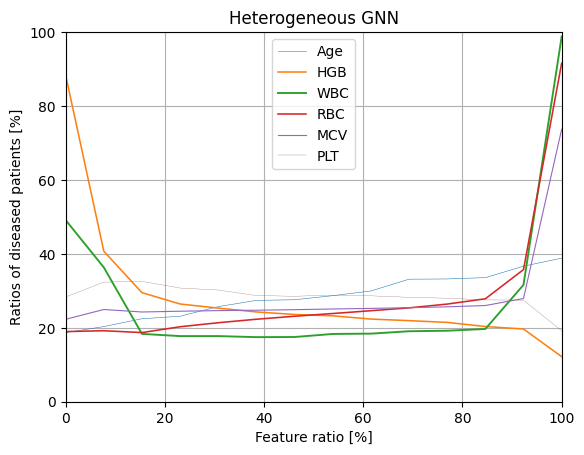

In [10]:
feature_importance.plot_feature_importance(model, title="Heterogeneous GNN")

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plotted_features = []
X_all_fv = X_all_fv if torch.is_tensor(X_all_fv) else torch.from_numpy(X_all_fv)
X_all_fv = X_all_fv.cpu()
y_pred = y_pred_all.cpu()
for feature in FEATURES:
    sepsis_ratios = []
    for feature_value in X_all_fv[:, FEATURE_DICT[feature]].unique():
        feature_mask = X_all_fv[:, FEATURE_DICT[feature]] == feature_value
        uniques, counts = torch.unique(y_pred[feature_mask], return_counts=True)
        if len(counts) == 2:
            sepsis_ratios.append(counts[1] / (counts[0] + counts[1]))
        else:
            sepsis_ratios.append(torch.tensor(0) if uniques[0] == 0 else torch.tensor(counts[0]))
    if feature == SEX__CAT_COLUMN_NAME:
        continue
        diff = sepsis_ratios[1] - sepsis_ratios[0]
        sepsis_ratios = [sepsis_ratios[0] + i/steps * diff for i in range(steps)]        
    sepsis_ratios = list(map(lambda r: r*100, sepsis_ratios))
    plt.plot(np.linspace(0, 100, steps, endpoint=True), sepsis_ratios)
plt.xlabel("Feature ratio [%]")
plt.ylabel("Ratios of diseased patients [%]")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.title("Heterogeneous GNN")
plt.legend(list(filter(lambda f: f != SEX__CAT_COLUMN_NAME, FEATURES)))
plt.show()

NameError: name 'X_all_fv' is not defined

In [ ]:
from torchmetrics import AUROC

auroc_metric = AUROC(task="binary")
with torch.inference_mode():
    model.eval()
    pred = model(graph.x, graph.edge_index) 
    pred_patient = torch.sigmoid(torch.squeeze(pred[test_l_mask]))
    auroc = auroc_metric(pred_patient, graph.y[test_l_mask])
    print(f"AUROC: {auroc.item():.4f}")

In [ ]:
from torchmetrics import AUROC
from sklearn import metrics

auroc_metric = AUROC(task="binary")
with torch.inference_mode():
    model.eval()
    pred = model(graph.x, graph.edge_index) 
    pred_patient = torch.sigmoid(torch.squeeze(pred[test_l_mask]))
    
    confusion_matrix = metrics.confusion_matrix(graph.y[test_l_mask].cpu(),
                                                    torch.round(pred_patient).type(torch.int).cpu())
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()

In [ ]:
import time 
for i in range(20000):
    print("Waiting")
    time.sleep(60)